Importem les llibreries necessaries per a la realització del projecte.

In [2]:
import pandas as pd
from pandas import plotting
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# 1. Preprocessament de Dades

En aquesta secció, realitzarem el pre-processament de les dades per preparar-les per a la construcció de models de detecció de phishing.

#### <b>1.1 Lectura de Dades</b>


Primer, llegim el conjunt de dades des del fitxer CSV i mostrem les primeres files per entendre la seva estructura.

In [4]:
data = pd.read_csv("dataset_phishing.csv")
data.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


#### <b>1.2 Anàlisi Exploratori de Dades</b>

A continuació, realitzem un anàlisi exploratori de les dades per comprendre millor el conjunt de dades. Això inclou una descripció estadística, la comprovació de valors nuls, la identificació dels tipus de dades, la informació sobre el nombre de files i columnes, i la cerca de files duplicades.

In [ ]:
# Obtenim una descripció completa del dataset.
data.describe([x*0.1 for x in range(10)])

In [ ]:
# Informació sobre el nombre de files i columnes.
data.info()

In [ ]:
# Nombre de valors nuls en cada columna.
data.isnull().sum()

In [ ]:
# Nombre de files duplicades.
data.duplicated().sum()

##### <b>1.2.1 Correlació de caracteristiques</b>

Avaluarem la correlació de cada característica amb la variable objectiu per obtenir un sentit inicial de la seva importància. Les característiques que tenen una correlació molt baixa es poden considerar per a l'eliminació.

In [ ]:
# Convertim la columna 'status' a valors numèrics (1 per a 'phishing' i 0 per a 'legitimate')
data['status_numeric'] = data['status'].apply(lambda x: 1 if x == 'phishing' else 0)

# Calculem la correlació de cada característica amb la columna 'status_numeric'
correlations = data.drop(columns=['url', 'status']).corrwith(data['status_numeric']).sort_values()

# Visualitzem les correlacions
plt.figure(figsize=(10, 20))
sns.barplot(x=correlations, y=correlations.index)
plt.title('Correlació de les característiques amb la variable objectiu')
plt.xlabel('Correlació')
plt.ylabel('Característiques')
plt.show()

A partir del diagrama de correlació, podem veure com cada característica es correlaciona amb la variable de destinació. 

Important:

    · Una correlació propera a 1 indica una forta relació positiva.
    · Una correlació propera a -1 indica una forta relació negativa.
    · Una correlació propera a 0 indica poca o cap relació.

Basant-nos en això, podríem considerar eliminar característiques que tenen una correlació molt propera a 0, ja que podrien no contribuir molt al poder predictiu d'un model. No obstant això, els mantindrem de moment i podríem revisar aquesta decisió després de l'avaluació del model.

#### <b>1.3 Manipulació de Dades</b>

En aquesta secció, realitzem les següents etapes de pre-processament de dades:

En primer lloc, haurem de guardar en una nova variable el conjunt de dades original per a poder fer modificacions sobre aquesta.

In [5]:
data_preprocessada = data

Eliminarem la columna "url" ja que és única per a cada fila i no aportarà informació útil per al model de classificació. En aquest cas, estem simplificant el conjunt de dades eliminant una característica que no és rellevant per a la nostra anàlisi.

In [6]:
data_preprocessada = data_preprocessada.drop(columns=['url'])
data_preprocessada.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,37,19,0,3,0,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,77,23,1,1,0,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,126,50,1,4,1,0,1,2,0,3,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,18,11,0,2,0,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,55,15,0,2,2,0,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


##### <b>1.3.1 Tractament de Valors Nuls</b>

· Per a les <b>columnes numèriques</b>, substituïm els valors nuls per la mitjana de la columna. <br>
· Per a les <b>columnes categòriques</b>, substituïm els valors nuls pel valor més freqüent de la columna.

In [7]:
# Tractament de valors nuls
for column in data_preprocessada.select_dtypes(include=['int', 'float']).columns:
    data_preprocessada[column].fillna(data_preprocessada[column].mean(), inplace=True)

for column in data_preprocessada.select_dtypes(include=['object']).columns:
    data_preprocessada[column].fillna(data_preprocessada[column].mode()[0], inplace=True)

##### <b>1.3.2 Eliminar columnes Redundants</b>

Simplificarem el conjunt de dades. 
Analitzem si hi ha alguna columna que pugui ser redundant o no útil per a la nostra anàlisi. 
Revisem les estadístiques descriptives de les columnes per veure si alguna d'elles presenta variància zero o valors constants, ja que aquestes columnes no aportarien informació útil per a la majoria d'algorismes.

In [8]:
# Obtenim les estadistiques de les columnes numeriques.
desc_stats = data_preprocessada.describe()

# Identifiquem les columnes amb 0 variança (desviació estàndard igual a zero)
zero_variance_columns = desc_stats.columns[desc_stats.loc["std"] == 0]

zero_variance_columns

Index(['nb_or', 'ratio_nullHyperlinks', 'ratio_intRedirection',
       'ratio_intErrors', 'submit_email', 'sfh'],
      dtype='object')

Les columnes següents presenten variància zero, la qual cosa significa que tenen el mateix valor en totes les files:

    · nb_or
    · ratio_nullHyperlinks
    · ratio_intRedirection
    · ratio_intErrors
    · submit_email
    · sfh
    
Aquestes columnes poden ser considerades com a redundants ja que no aporten informació variable al nostre model. Per tant, es recomana eliminar-les del conjunt de dades.

A continuació, procedirem a eliminar aquestes columnes del conjunt de dades.​

In [9]:
# Remove the zero variance columns from the dataset
data_preprocessada = data_preprocessada.drop(columns=zero_variance_columns)

# Display the first few rows of the cleaned dataset
data_preprocessada.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_eq,nb_underscore,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,37,19,0,3,0,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,77,23,1,1,0,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,126,50,1,4,1,0,1,2,3,2,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,18,11,0,2,0,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,55,15,0,2,2,0,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


##### <b>1.3.3 Conversió de Dades Categòriques a Dades Numèriques</b>

· Utilitzem <b>LabelEncoder</b> per transformar les columnes categòriques en dades numèriques.

In [10]:
# Conversió de dades categòriques a numèriques
le = LabelEncoder()
for column in data_preprocessada.columns:
    if data_preprocessada[column].dtype == type(object):
        data_preprocessada[column] = le.fit_transform(data_preprocessada[column])

##### <b>1.3.4 Normalització de Dades Numèriques</b>

Normalitzem les dades numèriques en un rang de 0 a 1.

In [11]:
# Normalització de dades numèriques
for column in data_preprocessada.columns:
    if data_preprocessada[column].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
        data_preprocessada[column] = (data_preprocessada[column] - data_preprocessada[column].min()) / (data_preprocessada[column].max() - data_preprocessada[column].min())

Ara que les dades han estat pre-processades, estan llestes per ser utilitzades per a la construcció i avaluació de models de detecció de phishing.

In [10]:
# Dades pre-processades
data_preprocessada.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_eq,nb_underscore,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,0.015347,0.071429,0.0,0.086957,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.001542,0.000854,0.000000,1.0,1.0,0.4,0.0
1,0.039902,0.090476,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,1.0,0.0,0.0,0.002615,0.448471,0.000000,0.0,1.0,0.2,1.0
2,0.069982,0.219048,1.0,0.130435,0.023256,0.0,0.333333,0.105263,0.157895,0.111111,...,1.0,0.0,0.0,0.000503,0.311656,0.541310,0.0,1.0,0.0,1.0
3,0.003683,0.033333,0.0,0.043478,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,1.0,0.0,0.0,0.002112,0.000854,0.010004,0.0,0.0,0.3,0.0
4,0.026397,0.052381,0.0,0.043478,0.046512,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.007543,0.635341,0.000810,0.0,0.0,0.6,0.0


#### <b>1.4 Histogrames i Boxplot</b>

Crearem gràfics de caixes (boxplots) i histogrames per visualitzar la distribució de les característiques numèriques en el conjunt de dades pre-processades i originals. Aquests gràfics ens ajudaran a entendre millor com es distribueixen les dades i a identificar valors extrems (outliers).

##### <b>1.4.1 Gràfics de Caixes (Boxplots)</b>

Els gràfics de caixes són útils per representar visualment la distribució i la variabilitat de les dades numèriques. Ens mostren la mediana, els quartils i els valors extrems

<b>· Dades originals</b>

In [ ]:
# Creació de gràfics de caixes més grans per a característiques numèriques
plt.figure(figsize=(36, 30)) 
sns.set(style="whitegrid")

# Seleccionem les característiques numèriques per als quals volem generar els boxplots
features_for_boxplot = data.select_dtypes(include=['int', 'float'])

# Dibuixem els gràfics de caixes
sns.boxplot(data=features_for_boxplot, orient="h", palette="Set2")
plt.title("Boxplots de Característiques Numèriques")
plt.xlabel("Valor")
plt.show()

<b>· Dades pre-processades</b>

In [ ]:
# Creació de gràfics de caixes més grans per a característiques numèriques
plt.figure(figsize=(36, 30)) 
sns.set(style="whitegrid")

# Seleccionem les característiques numèriques per als quals volem generar els boxplots
features_for_boxplot = data_preprocessada.select_dtypes(include=['int', 'float'])

# Dibuixem els gràfics de caixes
sns.boxplot(data=features_for_boxplot, orient="h", palette="Set2")
plt.title("Boxplots de Característiques Numèriques")
plt.xlabel("Valor")
plt.show()

##### <b>1.4.1 Histogrames</b>

Els histogrames mostren la distribució de les dades numèriques i ens permeten veure la forma de la distribució.

<b>· Dades originals</b>

In [ ]:
# Creació d'histogrames més grans per a característiques numèriques
plt.figure(figsize=(56, 30))  
sns.set(style="whitegrid")

# Seleccionem les característiques numèriques per als quals volem generar histogrames
features_for_histogram = data.select_dtypes(include=['int', 'float'])

# Dibuixem els histogrames
for feature in features_for_histogram.columns:
    sns.histplot(data[feature], kde=True, bins=20, label=feature)

plt.title("Histogrames de Característiques Numèriques")
plt.xlabel("Valor")
plt.legend()
plt.show()

<b>· Dades pre-processades</b>

In [ ]:
# Creació d'histogrames més grans per a característiques numèriques
plt.figure(figsize=(56, 30))  
sns.set(style="whitegrid")

# Seleccionem les característiques numèriques per als quals volem generar histogrames
features_for_histogram = data_preprocessada.select_dtypes(include=['int', 'float'])

# Dibuixem els histogrames
for feature in features_for_histogram.columns:
    sns.histplot(data_preprocessada[feature], kde=True, bins=20, label=feature)

plt.title("Histogrames de Característiques Numèriques")
plt.xlabel("Valor")
plt.legend()
plt.show()

#### <b>1.5 PCA (Principal Component Analysis)</b>

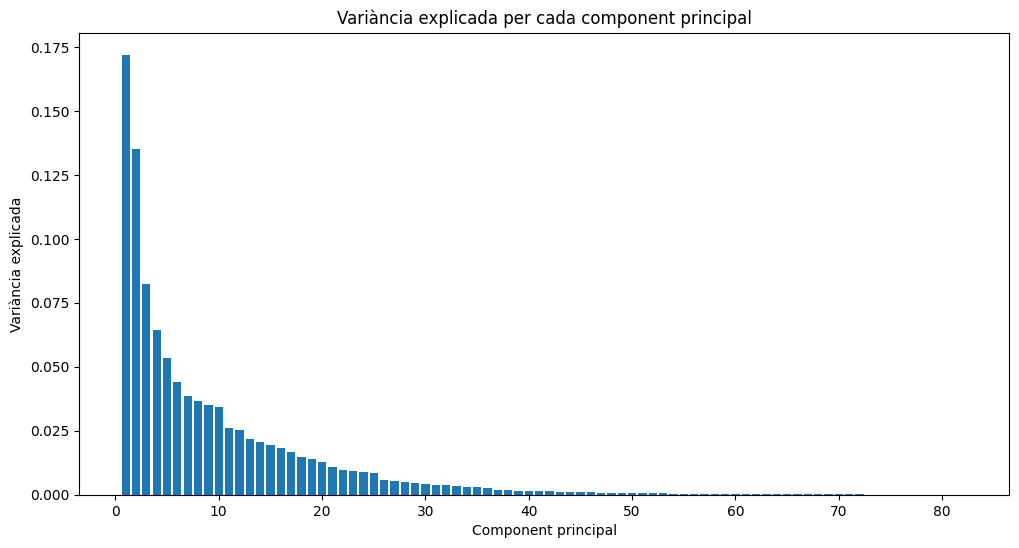

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apliquem PCA
pca = PCA()
components = pca.fit_transform(data_preprocessada)

# Visualitzem la variància explicada per cada component principal
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Component principal')
plt.ylabel('Variància explicada')
plt.title('Variància explicada per cada component principal')
plt.show()


A partir de la visualització, podem fer les següents observacions:

    1. Declivi ràpid inicial: Les primeres components principals expliquen una quantitat significativa de la variabilitat de les dades, amb un declivi ràpid en la variància explicada a mesura que augmenta el número de components.
    
    2. Plateau després d'unes poques components: Després d'un cert número de components (aproximadament 10-15), la variància explicada per cada component addicional disminueix significativament, arribant a un plateau. Això indica que la major part de la informació està continguda en les primeres components.

Aquestes observacions suggerixen que podríem reduir la dimensió del conjunt de dades utilitzant només les primeres components principals sense perdre massa informació. Aquesta reducció podria ser útil per visualitzar les dades o per accelerar l'entrenament de models de machine learning.

A continuació, podem calcular la variància acumulada explicada per les components per determinar quantes d'elles s'haurien d'utilitzar per capturar una determinada quantitat de la variabilitat total (per exemple, el 95%).​

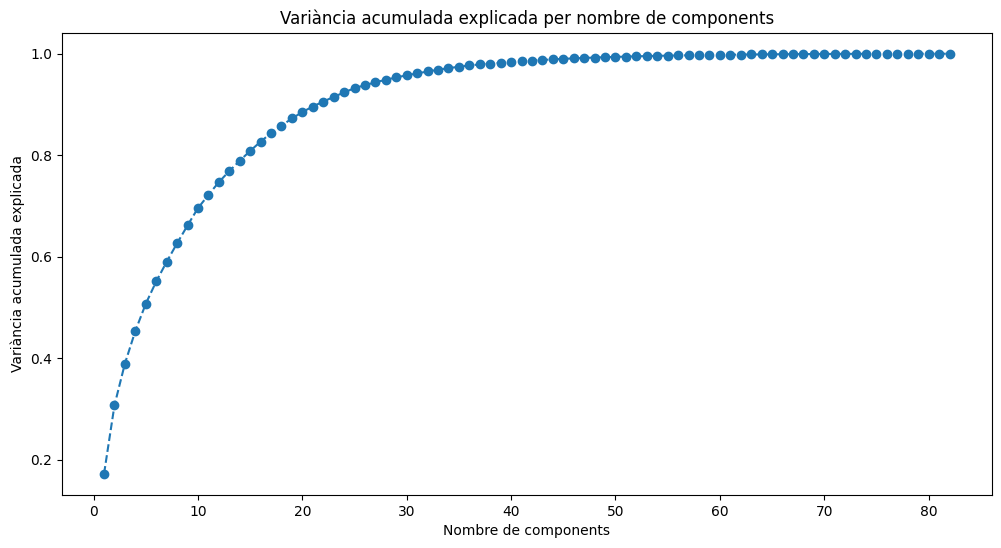

29

In [14]:
# Calculem la variància acumulada explicada
variancia_acumulada = pca.explained_variance_ratio_.cumsum()

# Visualitzem la variància acumulada
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, marker='o', linestyle='--')
plt.xlabel('Nombre de components')
plt.ylabel('Variància acumulada explicada')
plt.title('Variància acumulada explicada per nombre de components')
plt.show()

# Determinem el nombre de components necessaris per explicar almenys el 95% de la variància
components_95_variancia = sum(variancia_acumulada < 0.95) + 1

components_95_variancia

La visualització mostra la variància acumulada explicada a mesura que augmentem el nombre de components principals. A partir d'aquesta, podem observar que:

    1. La variància acumulada augmenta ràpidament amb les primeres components i comença a estabilitzar-se a mesura que s'afegeixen més components.

    2. Per explicar almenys el 95% de la variància total de les dades, necessitaríem utilitzar 29 components principals.

In [15]:
# Reajustem el PCA amb 29 components
pca_29 = PCA(n_components=components_95_variancia)
data_reduida = pca_29.fit_transform(data_preprocessada)

# Mostrem les primeres files de la representació reduïda
data_reduida[:5]

array([[-0.44858827, -0.34988644, -0.00386873, -0.37177355,  0.12117688,
        -0.38584044,  0.5599586 , -0.18844766,  0.58173657,  0.94191919,
         0.45144403, -0.04861193, -0.05918466, -0.133072  , -0.08888731,
         0.19386683,  0.09802835, -0.25711418,  0.20805511, -0.32757954,
         0.22574491,  0.07970238,  0.21006726, -0.47200619, -0.25638282,
         0.29960119,  0.09376465,  0.03283339, -0.2369985 ],
       [ 0.25669668, -1.18315932,  0.11864712,  0.01764551, -0.63524821,
         0.17898932,  0.30886429,  0.50645501, -0.17667736, -0.39388181,
        -0.61666302,  0.30963665, -0.56757698, -0.02673271,  0.07861568,
        -0.00983737,  0.27002427, -0.00653447, -0.08178135, -0.18113468,
        -0.28895363, -0.06920075, -0.16721503, -0.066702  ,  0.11177719,
        -0.01801447, -0.02515382, -0.19938164, -0.00690545],
       [ 0.55723092, -1.30716549,  0.33681912,  1.00540177,  0.02310385,
         1.10870918, -0.08958979, -0.31360428, -0.27298509, -0.41795975,
  

# 2. Criteris d'avaluació dels models de mineria de dades

Separar Característiques i Variable Objectiu

In [16]:
# Separació de les característiques i la variable objectiu
X = data_preprocessada.drop('status', axis=1)  # Eliminem la columna objectiu
y = data_preprocessada['status']  # La columna objectiu

Divisió en Conjunts d'Entrenament i Prova

In [17]:
# Divisió del conjunt de dades en entrenament i prova
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Configuració de Validació Creuada Estratificada

In [18]:
# Configuració de la validació creuada
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

Creació i Entrenament del Model de Random Forest

In [19]:
# Creació del model de Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

Avaluació del Model

In [ ]:
# Avaluació del model utilitzant precisió, recuperació i puntuació F1
precision = cross_val_score(rf_classifier, X_train, y_train, cv=skf, scoring='precision')
recall = cross_val_score(rf_classifier, X_train, y_train, cv=skf, scoring='recall')
f1_score = cross_val_score(rf_classifier, X_train, y_train, cv=skf, scoring='f1')

print(f'Precisió mitjana: {precision.mean()}')
print(f'Recuperació mitjana: {recall.mean()}')
print(f'Puntuació F1 mitjana: {f1_score.mean()}')

Visualització gràfica dels resultats

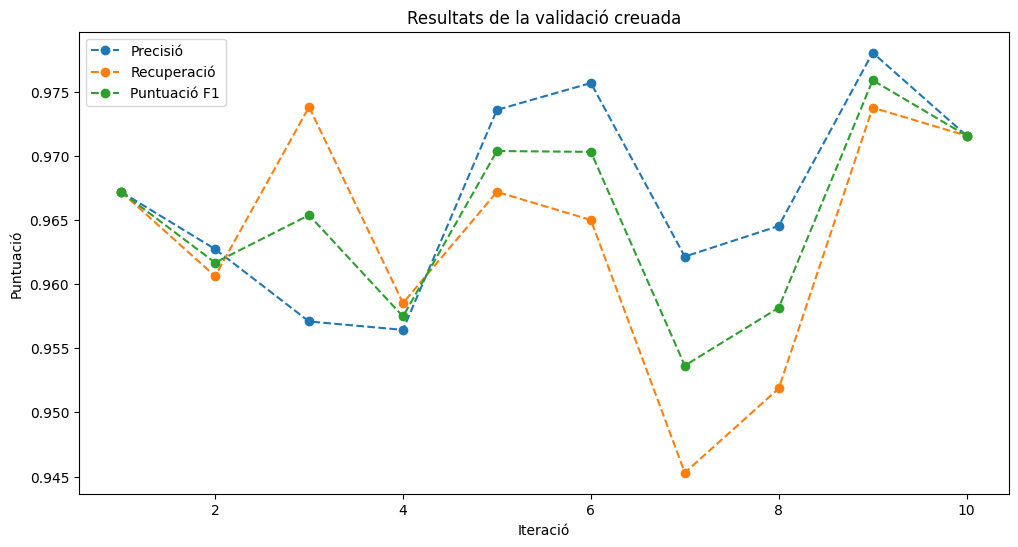

In [21]:
# Visualitzacó dels resultats
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), precision, marker='o', linestyle='--', label='Precisió')
plt.plot(range(1, 11), recall, marker='o', linestyle='--', label='Recuperació')
plt.plot(range(1, 11), f1_score, marker='o', linestyle='--', label='Puntuació F1')
plt.xlabel('Iteració')
plt.ylabel('Puntuació')
plt.title('Resultats de la validació creuada')
plt.legend()
plt.show()
